In [33]:
import warnings
import numpy as np
import xarray as xr
import scipy.interpolate as ip
import matplotlib.pyplot as plt

def set_fill_value(ds):
    '''
    No _FillValue attribute for coordinates, -1e34 for data variables
    function from Elizabeth Yankovsky's notebooks
    '''
    for var in ds.coords:
        ds[var].encoding['_FillValue'] = None
        if 'missing_value' in ds[var].encoding:
            del ds[var].encoding['missing_value']

    for var in ds.data_vars:
        if ds[var].data.dtype in ['float32', 'float64']:
            ds[var].encoding['_FillValue'] = -1.e34
        if 'missing_value' in ds[var].encoding:
            del ds[var].encoding['missing_value']

    return ds

In this notebook we'll 
1. set up a standalone configuration of the MOM6 ocean model with the Marine Biogeochemistry Library (MARBL), and 
2. run a flat-bottom channel configuration with periodic boundary conditions, using initial conditions adapted from the Antarctic Cricumpolar Current in a realistic global run of CESM.

Acknowledgements: 
- Mike Levy for the MOM6+MARBL source code and installation instructions 
- Scott Bachman for the MOM6 Eady channel configuration
- Elizabeth Yankovsky for some MARBL initialisation routines from which this was adapted

# 1. Getting the MOM6+MARBL code
---
This section is based on [This guide on GitHub](https://github.com/mnlevy1981/MOM6-examples/wiki/Building-MOM6-examples-with-MARBL).
MOM6 is installed as the ocean component of the Community Earth System Model (CESM), so we'll install CESM without any other components

1. Create a new directory where the CESM source code will be housed and change into this directory.
2. Clone the cesm2_3_alpha12b+mom6_marbl branch of CESM, which contains the branch of MOM6 with the MARBL driver:

    `git clone -b cesm2_3_alpha12b+mom6_marbl http://github.com/mnlevy1981/cesm.git cesm2_3_alpha12b+mom6_marbl`

3. This creates a skeletal version of CESM in the directory `cesm2_3_alpha12b+mom6_marbl` (henceforth `$CESM_ROOT`)  which we'll populate with the "external" components of the [Flexible Modeling System(FMS)](https://www.gfdl.noaa.gov/fms/) as well as [MOM6](https://www.gfdl.noaa.gov/mom-ocean-model/):

    ```cd cesm2_3_alpha12b+mom6_marbl ; ./manage_externals/checkout_externals -v fms mom```
    
    ... `checkout_externals` is a routine that fetches further code from the FMS and MOM repositories, which are elsewhere on GitHub.
4. Lastly, we add MARBL:

```
cd components/mom/
git checkout MARBL_support
cd MOM6
git checkout mnlevy1981/add_MARBL
cd pkg/MARBL/
git checkout development
cd ../../../ # get back to components/mom
```

MARBL itself exists as a separate codebase (designed to be modular and capable of interfacing with any ocean model). This version of MOM includes modules for interfacing with MARBL, and this procedure downloads the MARBL code base to be interfaced with.

# 2. Compiling
---
## Cheyenne
Load the following modules:

```
module load ncarenv/1.3 intel/19.0.5 mpt/2.22 netcdf/4.7.3
module load ncarcompilers/0.5.0
```
We can then use Michael Levy's script for compiling on Cheyenne:
```
cd standalone/build
./build_examples-cheyenne.sh
```

This produces a `MOM6` executable at `$CESM_ROOT/components/mom/standalone/build/intel/MOM6/MOM6`

## OSX (tested on a 2023 M2 MacBook Pro)
Based on [these instructions](https://github.com/NOAA-GFDL/MOM6-examples/wiki/Compiling-on-MacBook-M1-chip-using-conda-environment), create a conda environment for the MOM6 setup

```
conda create --name mom6
conda activate mom6
conda install -c conda-forge gfortran -y
conda install -c conda-forge netcdf4 -y
conda install -c conda-forge netcdf-fortran -y
conda install -c conda-forge mpich -y
```

At `$CESM_ROOT/components/mom/standalone/templates/` there are a selection of `.mk` files. Replace (create a backup!) `homebrew-gnu.mk` with the file `osx-gcc10.mk` located [at this link](https://github.com/mom-ocean/mkmf/blob/14fe9570efba67f232bbd96ed4f8360eea18c54d/templates/osx-gcc10.mk). 

Lastly, compile with `$CESM_ROOT/components/mom/standalone/build/build_examples-darwin.sh`

This produces a `MOM6` executable at `$CESM_ROOT/components/mom/standalone/build/gnu`

# 3. Setting up the Eady channel configuration (default setup without MARBL)
---
The code for the MOM6 Eady channel configuration is included in the same directory as this notebook. 
This configuration uses a flat-bottom 4000m deep domain with 50 layers extending 25° from 65°S over 50 grid points in the meridional (on an f-plane) and 300° from 0°E over 600 grid points in the zonal. These parameters can be changed at runtime. The configuration is a baroclinic spin-down: we'll initialise it with an unstable initial condition which decays into an eddy field and ultimately comes to rest. There is no surface forcing and river input has been turned off.

Create a directory where we will run the model (we'll call this `$CHANNEL_RUNDIR`) and two subdirectories `INPUT` and `RESTART`. Copy the code from `eady_channel_code` into `$CHANNEL_RUNDIR`.
There are 6 files in the directory:
- `input.nml` is a namelist that allows the user to make CESM-level runtime choices including the start date and length of the run
- `MOM_input` is the namelist allowing the user to control MOM6 parameters. Parameters that are not set in `MOM_input` revert to their default values, and all parameter values at runtime are printed in the file `MOM_parameter_doc.all`. A second file, `MOM_override`, can be used to override parameters in this file for testing
- `diag_table` allows the user to decide what diagnostics to produce as output, their frequency, and any averaging that is applied to them. [More information can be found here.](https://mom6.readthedocs.io/en/main/api/generated/pages/Diagnostics.html)
- `run_job_cheyenne.sh` a bash script to start a run on Cheyenne using `qsub run_job_cheyenne.sh`. Change the project code and user email lines as necessary.
- `run_job_osx.sh` a bash script to start a run on OSX.

Currently, `MOM_input` looks for initial conditions in `INPUT/InitialConditions_MARBL.nc`, which is a file we'll create from existing CESM data for the purposes of the run.

# 4. Creating input files to run the channel configuration with MARBL
We'll set up the channel with initial conditions that are constant in the zonal and have a meridional and vertical profile typical of the Southern Ocean. To do this, we'll load in a region of CESM data from the Southern Ocean and take a zonal average. This only applies to users on the Cheyenne system. If you do not have access to Cheyenne, these latitude-depth arrays are saved in "initial_profiles", and we'll use those instead.

## i. Load in CESM data (Cheyenne)

In [2]:
# Input directory for CESM data:
cesm_in_dir='/glade/work/mlevy/cesm_inputdata/'

# Choose latitudes on CESM grid that contain 60°S to 35°N
latidx=slice(89,149)

# time invariant output from a CESM run on the tx0.66v1 grid
GRID_FILE             =  xr.open_dataset(f'{cesm_in_dir}/mom6.static.nc').isel(yh=latidx).isel(yq=latidx)
# topography for CESM run on the tx0.661v1 grid
TOPO_FILE             = xr.open_dataset('/glade/p/cesmdata/cseg/inputdata/ocn/mom/tx0.66v1/ocean_topog_200701.nc').isel(ny=latidx)
# MOM's reported initial conditions from a CESM run on the tx0.66v1 grid
IC_FILE               =  xr.open_mfdataset(f'{cesm_in_dir}/MOM_IC*.nc', compat='override', join='override', combine_attrs='override').isel(Time=0).drop('Time').isel(lath=latidx).isel(latq=latidx)


In [6]:
# Make a 3D topography mask for the CESM data at layer interface points (f) and centre points (c) by
# creating an array which is 1 where the layer depth is < the bottom depth and 0 elsewhere:

layerdepth_c=np.tile(IC_FILE.Layer.values[:,None,None],(1,len(IC_FILE.lath),len(IC_FILE.lonh)))
botdepth_c=np.tile(TOPO_FILE.depth.values[None,:,:],(len(IC_FILE.Layer),1,1))
topmask_c=np.zeros(np.shape(layerdepth_c))
topmask_c[layerdepth_c>botdepth_c]=0
topmask_c[layerdepth_c<botdepth_c]=1

layerdepth_f=np.tile(IC_FILE.Interface.values[:,None,None],(1,len(IC_FILE.lath),len(IC_FILE.lonh)))
botdepth_f=np.tile(TOPO_FILE.depth.values[None,:,:],(len(IC_FILE.Interface),1,1))
topmask_f=np.zeros(np.shape(layerdepth_f))
topmask_f[layerdepth_f>botdepth_f]=0
topmask_f[layerdepth_f<botdepth_f]=1

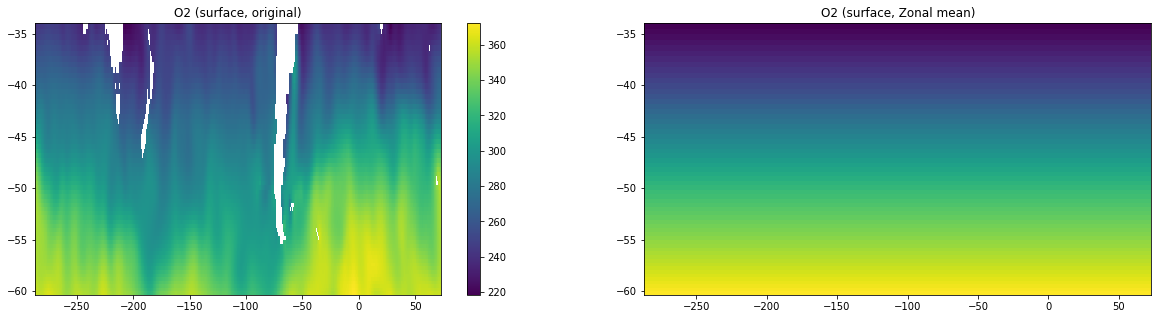

In [3]:
# Display what the zonal average of a tracer profile looks like on the CESM grid:

# Tracer name (see list(IC_FILE.data_vars))
v='O2'

# Get the x and y coordinate strings for this variable
xco=list(IC_FILE[v].coords)[1]
yco=list(IC_FILE[v].coords)[0]

# Select only the surface layer
if 'Layer' in list(IC_FILE[v].coords):
    F=IC_FILE[v].isel(Layer=0).values
    F[TOPO_FILE.mask==0]=np.nan
elif 'Interface' in (IC_FILE[v].coords):
    F=IC_FILE[v].isel(Interface=0).values
    F[TOPO_FILE.mask==0]=np.nan            
else:
    F=IC_FILE[v].values

    
## PLOT     
fig,ax=plt.subplots(1,2)

# Plot the original tracer distribution
p=ax[0].pcolormesh(IC_FILE[xco],IC_FILE[yco],F)
fig.colorbar(p,ax=ax[0])
ax[0].set_title(v+' (surface, original)')

# Plot the zonal average distribution
lenlon=len(IC_FILE.coords['lonh']) #how many times to repeat the profile
ax[1].pcolormesh(IC_FILE[xco],IC_FILE[yco],np.tile(np.nanmean(F,axis=1,keepdims=1),540))
ax[1].set_title(v+' (surface, Zonal mean)')
fig.set_size_inches(20,5)

## ii. Define channel domain:


In [4]:
# Get these from MOM_input
SOUTHLAT = -60
WESTLON = 0
LENLAT = 25
LENLON = 300
NIGLOBAL = 600
NJGLOBAL = 50
MAXIMUM_DEPTH=4e3 # note assumes "THICKNESS_CONFIG='uniform'"
NK = 50

#####################################################################################
nx,ny,nz=NIGLOBAL,NJGLOBAL,NK

# Create lat&lon coords for NetCDF
latq=np.linspace(SOUTHLAT,SOUTHLAT+LENLAT,ny+1)
lath=(latq[1:]+latq[:-1])/2

lonq=np.linspace(WESTLON,WESTLON+LENLON,nx+1)
lonh=(lonq[1:]+lonq[:-1])/2

Interface=np.linspace(0,MAXIMUM_DEPTH,nz+1)
Layer=(Interface[1:]+Interface[:-1])/2
#####################################################################################
# Values at/below the bottom will be NaN, which messes with the interpolation function
# as we only want a 4000m deep channel, we can choose not to take any information from below 
# a certain CESM layer index >4000m, avoiding this issue. There are 65 layers in CESM,
# we'll stick to the top 60:
kinterpmax=60 

# iii. interpolate zonally averaged profiles (Cheyenne)

<ipython-input-7-7a1918907320>:10: RuntimeWarning: Mean of empty slice
  np.nanmean(F,axis=2)[:kinterpmax,:])


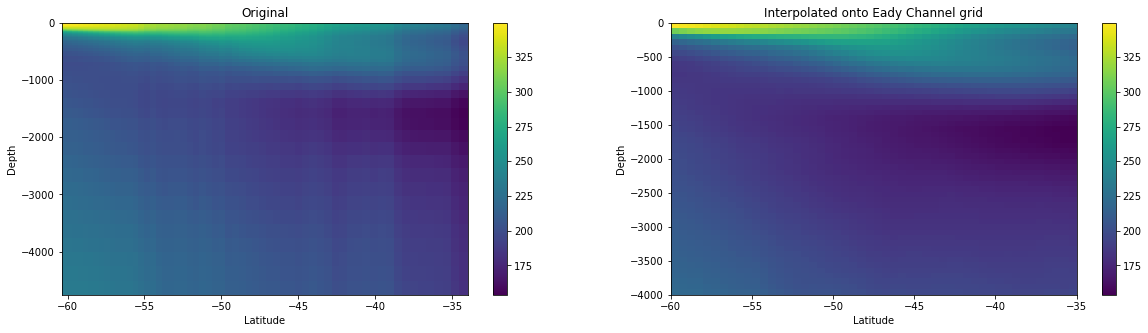

In [7]:
# Plot an example variable on the CESM grid and interpolated onto the channel grid
v='O2'
F=IC_FILE[v].values
# Mask everywhere on land/beneath the floor using the 3d topography mask we made
F[topmask_c==0]=np.nan

# Create a 2d interpolation function Fi over CESM lat and depth, using the zonal mean of the CESM field
Fi=ip.interp2d(IC_FILE.lath.values,\
               IC_FILE.Layer.values[:kinterpmax],\
               np.nanmean(F,axis=2)[:kinterpmax,:])

# Interpolate the field F onto the Eady Channel Grid in latitude and depth, and then tile it over longitude:
F_ECG=np.tile( Fi(lath,-Layer)[:,:,None],NIGLOBAL)

## PLOT:
fig,ax=plt.subplots(1,2)
p=ax[0].pcolormesh(IC_FILE.lath,-IC_FILE.Layer[:kinterpmax],IC_FILE[v].mean('lonh')[:kinterpmax,:])
ax[0].set_title('Original')
ax[0].set_xlabel('Latitude');ax[0].set_ylabel('Depth')
fig.colorbar(p,ax=ax[0])
ax[1].pcolormesh(lath,-Layer,Fi(lath,Layer))
ax[1].set_title('Interpolated onto Eady Channel grid')
ax[1].set_xlabel('Latitude');ax[1].set_ylabel('Depth')
fig.colorbar(p,ax=ax[1])
fig.set_size_inches(20,5)

In [ ]:
# Lastly, we create a new dataset, then go through all the variables in the CESM dataset and perform this zonal averaging/interpolation operation

warnings.filterwarnings("ignore", category=RuntimeWarning) # Optional, but cell output is bloated otherwise

ICDS=xr.Dataset(coords={'Interface':Interface,'Layer':Layer,'lath':lath,'latq':latq,'lonh':lonh,'lonq':lonq})
print('Going through CESM variables, taking zonal average and interpolating. Current variable:')
for v in list(IC_FILE.keys()):
    print(v)
    ################################   
    # Determine which grid points this variable is defined at
    coordlist=list(IC_FILE[v].coords)
    ################################    
    if 'lath' in coordlist:
        yvar='lath';yint=lath;
    elif 'latq' in coordlist:
        yvar='latq';yint=latq;
    if 'lonh' in coordlist:
        xvar='lonh';xint=lonh;
    elif 'lonq' in coordlist:
        xvar='lonq';xint=lonq;
    if 'Layer' in coordlist:
        zvar='Layer';zint=Layer;topo=topmask_c;
    elif 'Interface' in coordlist:
        zvar='Interface';zint=Interface;topo=topmask_f;
    ################################
    # Treat 2D and 3D variables differently
    if len(coordlist)==2: #2D
        F=IC_FILE[v].values
        # Only need to use surface topography:
        F[TOPO_FILE.mask==0]=np.nan
        # Only need to interpolate in latitude, not depth:
        Fi=ip.interp1d(IC_FILE[yvar].values,np.nanmean(F,axis=1))
        F_ECG=np.tile(Fi(yint)[:,None],(1,len(xint)))
    elif len(coordlist)==3: #3D
        F=IC_FILE[v].values
        # Use the 3d topography mask we made to avoid skewing zonal averages
        F[topo==0]=np.nan
        # Create interpolation function over latitude and depth (up to the max we chose earlier)
        Fi=ip.interp2d(IC_FILE[yvar].values,\
                       IC_FILE[zvar].values[:kinterpmax],\
                       np.nanmean(F,axis=2)[:kinterpmax])
        # Repeat over longitude throughout the channel
        F_ECG=np.tile(Fi(yint,zint)[:,:,None],(1,1,len(xint)))
    elif len(coordlist)==0: #0D, just copy the variable
        ICDS=ICDS.assign({v:IC_FILE[v]})
        continue
    else: 
        continue
    ICDS=ICDS.assign({v:xr.DataArray(F_ECG,dims=IC_FILE[v].dims,attrs=IC_FILE[v].attrs)})
ICDS=ICDS.assign_attrs(IC_FILE.attrs)

warnings.filterwarnings("default", category=RuntimeWarning) # Turn warnings back on

In [219]:
# Save the dataset without the longitude tiling to be used below for users who don't have access to Cheyenne
ICDS_za=ICDS.isel(lonq=slice(0,1),lonh=slice(0,1))
ICDS_za.to_netcdf('IC_zonavg_interp.nc')

## iv. Load in pre-prepared zonally averaged and interpolated data and tile it (if no access to Cheyenne)

In [ ]:
ICDS_za=xr.open_dataset('IC_zonavg_interp.nc')
ICDS=xr.Dataset(coords={'Interface':Interface,'Layer':Layer,'lath':lath,'latq':latq,'lonh':lonh,'lonq':lonq})
for v in list(ICDS_za.keys()):
    print(v)
    # We want to tile the array along the longitude dimension
    # We'll achieve this with broadcasting, multipying by an array of ones with shape (1,...,desired_number_of_lon_points)
    # Get the original shape of the variable:
    s=np.array(ICDS_nl[v].shape)
    # Mark where the shape is 1 (longitude) using a 0, mark where it's greater than 1 (other dimensions) with a 1
    s[s==1]=0;s[s>1]=1;
    if 'lonq' in ICDS_za[v].coords:        
        s[s==0]=len(lonq)
    if 'lonh' in ICDS_za[v].coords:
        s[s==0]=len(lonh)
    
    ICDS=ICDS.assign({v:xr.DataArray(ICDS_za[v].values*np.ones(s),dims=ICDS_za[v].dims,attrs=ICDS_za[v].attrs)})
ICDS=ICDS.assign_attrs(ICDS_za.attrs)
ICDS = set_fill_value(ICDS)

In [36]:
CHANNEL_RUNDIR='.' # Set this to the path defined in (3) above
ICDS = set_fill_value(ICDS)
ICDS.to_netcdf(CHANNEL_RUNDIR+'/INPUT/InitialConditions_MARBL.nc')

## vi. Create sedmient flux files to be read by MARBL
For now these will just be zero everywhere, but MARBL needs to read these to run.

In [26]:
# Sediment fluxes
DS=xr.Dataset(coords={'DEPTH_EDGES':Interface,'DEPTH':Layer,'lath':lath,'lonh':lonh})
DS=DS.assign({'FESEDFLUXIN'       :xr.DataArray(np.zeros((NK,NJGLOBAL,NIGLOBAL)),dims=['DEPTH','lath','lonh'])})
DS=DS.assign({'FESEDFLUXIN_oxic'  :xr.DataArray(np.zeros((NK,NJGLOBAL,NIGLOBAL)),dims=['DEPTH','lath','lonh'])})
DS=DS.assign({'FESEDFLUXIN_reduce':xr.DataArray(np.zeros((NK,NJGLOBAL,NIGLOBAL)),dims=['DEPTH','lath','lonh'])})
DS=DS.assign({'KMT'               :xr.DataArray(np.zeros((NJGLOBAL,NIGLOBAL)),dims=['lath','lonh'])})
DS=DS.assign({'TAREA'             :xr.DataArray(np.zeros((NJGLOBAL,NIGLOBAL)),dims=['lath','lonh'])})
DS=DS.assign_attrs({'description': 'Sediment fluxes for Eady channel configuration'})
DS.to_netcdf(CHANNEL_RUNDIR+'/INPUT/MARBL_FESEDFLUX_FILE.nc')

In [28]:
# Sediment fluxes
DS=xr.Dataset(coords={'DEPTH_EDGES':Interface,'DEPTH':Layer,'lath':lath,'lonh':lonh})
DS=DS.assign({'FESEDFLUXIN'       :xr.DataArray(np.zeros((NK,NJGLOBAL,NIGLOBAL)),dims=['DEPTH','lath','lonh'])})
DS=DS.assign({'TLAT'             :xr.DataArray(np.meshgrid(lonh,lath)[1],dims=['lath','lonh'])})
DS=DS.assign({'TLONG'             :xr.DataArray(np.meshgrid(lonh,lath)[0],dims=['lath','lonh'])})
DS=DS.assign({'KMT'               :xr.DataArray(np.zeros((NJGLOBAL,NIGLOBAL)),dims=['lath','lonh'])})
DS=DS.assign({'TAREA'             :xr.DataArray(np.zeros((NJGLOBAL,NIGLOBAL)),dims=['lath','lonh'])})
DS=DS.assign_attrs({'description': 'Sediment fluxes for Eady channel configuration'})
DS.to_netcdf(CHANNEL_RUNDIR+'/INPUT/MARBL_FEVENTFLUX_FILE.nc')

# 5. Running with a restart
Currently, initialising the model from rest with conditions taken from CESM induces a shock, so the time step (`DT` and `DT_THERM` in `MOM_input`) is kept small. After a few days, it is possible to run with a much larger time step, making the simulation much cheaper and faster.
If this behaviour is desired, the file `input_restart.nml` is provided. Here are the steps:
1. Run MOM6-MARBL as described above, but with `days = 5` (or some small number) in `input.nml`. Change `RESTINT` in `MOM_input`. This is the interval between creating restart files in the `RESTART` directory (in days). Setting it to 1 will work 
2. Swap `input.nml` for `input_restart.nml` and make sure that `date_init` in `input_restart.nml` corresponds to the date at which the final restart file is created
3. Modify `DT` (suggested setting 240 seconds) and `DT_THERM` (suggested setting 960 seconds) in `MOM_input`. 